Interest Point Detection

In [4]:
# 第一个代码单元格：导入所需库
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 用于显示图像的辅助函数
def show_image(image, title='Image', figsize=(8, 6)):
    plt.figure(figsize=figsize)
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [5]:
# 第二个代码单元格：Harris角点检测器类
class HarrisDetector:
    def __init__(self, k=0.04, window_size=3, threshold=0.01):
        """
        初始化Harris检测器
        参数:
        - k: Harris响应函数中的经验常数，通常为0.04-0.06
        - window_size: 计算局部梯度的窗口大小
        - threshold: 检测阈值，用于筛选角点
        """
        self.k = k
        self.window_size = window_size
        self.threshold = threshold

    def detect(self, image):
        """
        检测图像中的角点
        参数:
        - image: 输入图像
        返回:
        - keypoints: 角点位置列表 [x, y, response]
        """
        # 1. 确保图像是灰度图
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # 2. 计算x和y方向的梯度
        dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        
        # 3. 计算梯度乘积
        Ixx = dx * dx
        Ixy = dx * dy
        Iyy = dy * dy
        
        # 4. 使用高斯滤波器进行加权
        kernel_size = (self.window_size, self.window_size)
        Ixx = cv2.GaussianBlur(Ixx, kernel_size, 0)
        Ixy = cv2.GaussianBlur(Ixy, kernel_size, 0)
        Iyy = cv2.GaussianBlur(Iyy, kernel_size, 0)
        
        # 5. 计算Harris响应函数
        det = Ixx * Iyy - Ixy * Ixy
        trace = Ixx + Iyy
        response = det - self.k * trace * trace
        
        # 6. 非极大值抑制
        keypoints = []
        border = self.window_size // 2 + 1
        for y in range(border, response.shape[0] - border):
            for x in range(border, response.shape[1] - border):
                # 如果响应值大于阈值且是局部最大值
                window = response[y-1:y+2, x-1:x+2]
                if response[y, x] == np.max(window) and response[y, x] > self.threshold:
                    keypoints.append([x, y, response[y, x]])
                    
        return np.array(keypoints)

    def visualize(self, image, keypoints):
        """
        可视化检测到的角点
        """
        vis_img = image.copy()
        if len(vis_img.shape) == 2:
            vis_img = cv2.cvtColor(vis_img, cv2.COLOR_GRAY2BGR)
            
        for kp in keypoints:
            x, y = int(kp[0]), int(kp[1])
            cv2.circle(vis_img, (x, y), 3, (0, 0, 255), -1)
            
        return vis_img

In [6]:
# 第三个代码单元格：测试函数
def test_harris_detector(image_path, k=0.04, window_size=3, threshold=0.01):
    """
    测试Harris角点检测器
    """
    # 读取图像
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("无法读取图像，请检查图像路径是否正确")
    
    # 创建检测器
    detector = HarrisDetector(k=k, window_size=window_size, threshold=threshold)
    
    # 检测角点
    keypoints = detector.detect(image)
    
    # 可视化结果
    result = detector.visualize(image, keypoints)
    
    # 显示结果
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(f'Detected Corners (n={len(keypoints)})')
    plt.axis('off')
    
    # 显示局部放大图
    if len(keypoints) > 0:
        # 选择第一个关键点周围的区域
        x, y = int(keypoints[0][0]), int(keypoints[0][1])
        size = 50  # 放大区域的大小
        x1, x2 = max(x-size//2, 0), min(x+size//2, image.shape[1])
        y1, y2 = max(y-size//2, 0), min(y+size//2, image.shape[0])
        zoom_region = result[y1:y2, x1:x2]
        
        plt.subplot(133)
        plt.imshow(cv2.cvtColor(zoom_region, cv2.COLOR_BGR2RGB))
        plt.title('Zoomed Corner Region')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return keypoints


实验 1:
参数: k=0.04, window_size=3, threshold=0.01


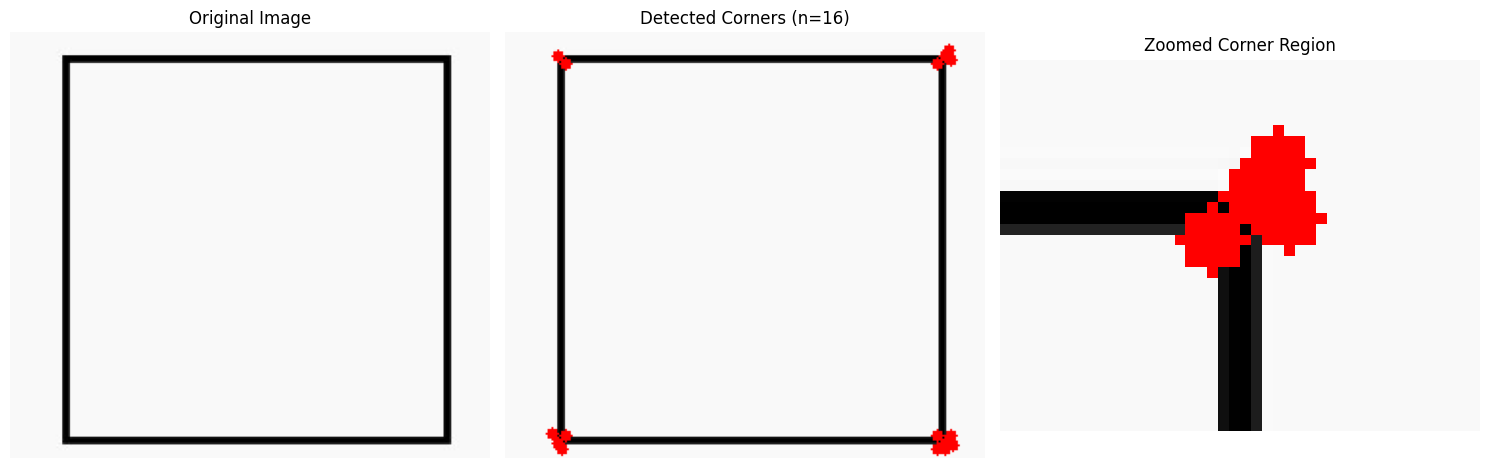

检测到的角点数量: 16

实验 2:
参数: k=0.05, window_size=5, threshold=0.02


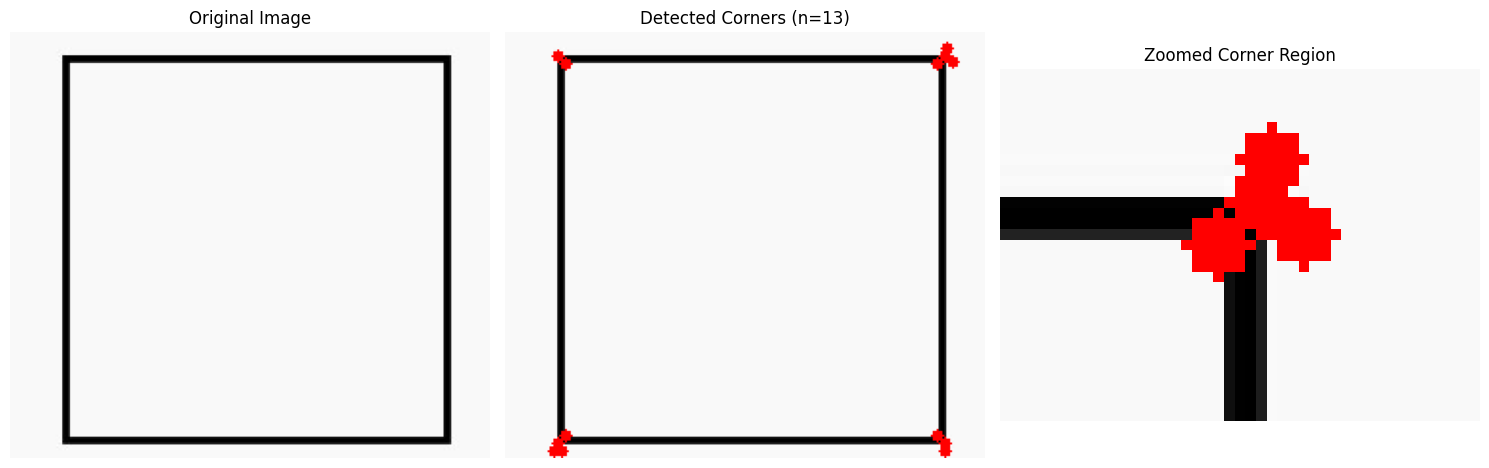

检测到的角点数量: 13

实验 3:
参数: k=0.06, window_size=3, threshold=0.005


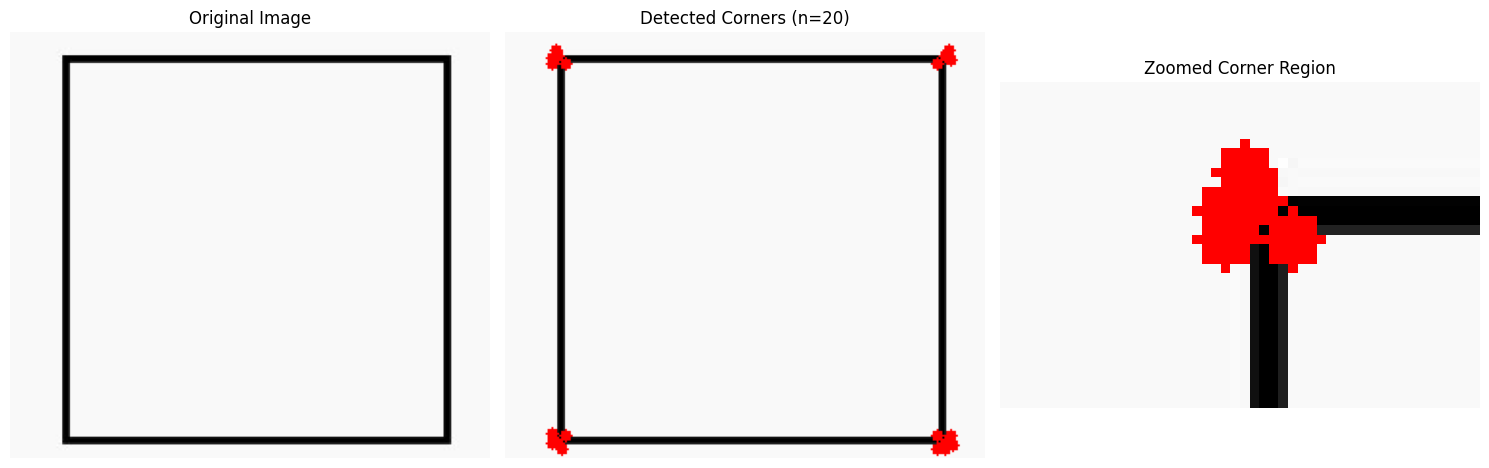

检测到的角点数量: 20


In [8]:
# 第四个代码单元格：参数实验
# 读取测试图像
image_path = './pic/triangle.jpg'  # 替换为您的图像路径

# 实验不同的参数组合
params = [
    {'k': 0.04, 'window_size': 3, 'threshold': 0.01},
    {'k': 0.05, 'window_size': 5, 'threshold': 0.02},
    {'k': 0.06, 'window_size': 3, 'threshold': 0.005}
]

for i, param in enumerate(params):
    print(f"\n实验 {i+1}:")
    print(f"参数: k={param['k']}, window_size={param['window_size']}, threshold={param['threshold']}")
    keypoints = test_harris_detector(image_path, **param)
    print(f"检测到的角点数量: {len(keypoints)}")

# Harris角点检测原理
## 什么是角点？
- 角点是图像中梯度在两个主方向上都有显著变化的点
- 例如在您的黑色正方形图像中，四个顶点都是角点，因为这些位置在水平和垂直方向都有明显的颜色变化
## 参数影响
1. k值 (0.04 - 0.06):
   k值越大，检测器越保守
   k值越小，更容易检测到角点
   通常k=0.04-0.06效果较好

2. window_size
   较大窗口：更平滑，抗噪声，但可能丢失细节
   较小窗口：保留更多细节，但容易受噪声影响

3. threshold
   较高阈值：只保留最强的角点
   较低阈值：检测更多潜在的角点

## 实际应用
Harris角点检测器广泛应用于：
1. 图像配准
2. 物体追踪
3. 运动检测
4. 三维重建
5. SLAM（同时定位与地图构建）

SIFT-like Feature Descriptor

In [ ]:
class SIFTlikeDescriptor:
    def __init__(self, patch_size=16, num_bins=8):
        self.patch_size = patch_size
        self.num_bins = num_bins

    def compute_descriptor(self, image, keypoints):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        descriptors = []
        orientations = []

        for kp in keypoints:
            x, y = int(kp[0]), int(kp[1])
            patch = gray[y-self.patch_size//2:y+self.patch_size//2,
                         x-self.patch_size//2:x+self.patch_size//2]
            if patch.shape == (self.patch_size, self.patch_size):
                dx = cv2.Sobel(patch, cv2.CV_32F, 1, 0, ksize=3)
                dy = cv2.Sobel(patch, cv2.CV_32F, 0, 1, ksize=3)
                magnitude = np.sqrt(dx**2 + dy**2)
                angle = np.arctan2(dy, dx) * (180 / np.pi) % 360

                hist, bin_edges = np.histogram(angle, bins=self.num_bins, range=(0, 360), weights=magnitude)
                descriptors.append(hist)
                
                main_orientation = bin_edges[np.argmax(hist)]
                orientations.append(main_orientation)
        
        return np.array(descriptors), orientations

    def visualize(self, image, keypoints, orientations):
        vis_img = image.copy()
        if len(vis_img.shape) == 2:
            vis_img = cv2.cvtColor(vis_img, cv2.COLOR_GRAY2BGR)
        
        for (x, y), angle in zip(keypoints[:, :2], orientations):
            x, y = int(x), int(y)
            cv2.circle(vis_img, (x, y), 3, (0, 255, 0), -1)
            length = 10
            angle_rad = np.deg2rad(angle)
            end_x = int(x + length * np.cos(angle_rad))
            end_y = int(y + length * np.sin(angle_rad))
            cv2.arrowedLine(vis_img, (x, y), (end_x, end_y), (255, 0, 0), 1, tipLength=0.3)
        
        return vis_img

In [11]:
# 参数实验
# 读取测试图像
image_path = './pic/triangle.jpg'  # 替换为您的图像路径
#读取图像
image = cv2.imread(image_path)
if image is None:
    raise ValueError("无法读取图像，请检查图像路径是否正确")



# 实验不同的参数组合
params_harris = [
    {'k': 0.04, 'window_size': 3, 'threshold': 0.01},
    {'k': 0.05, 'window_size': 5, 'threshold': 0.02},
    {'k': 0.06, 'window_size': 3, 'threshold': 0.005}
]
params_sift=[
    {'patch_size': 8, 'num_bins': 8},
    {'patch_size': 16, 'num_bins': 8},
    {'patch_size': 16, 'num_bins': 16},
]
count=0
for i in params_harris:
    
    # 创建检测器
    detector = HarrisDetector(**i)
    # 检测角点
    keypoints = detector.detect(image)
    for j in params_sift:
        descriptor = SIFTlikeDescriptor(**j)
        descriptors, orientations = descriptor.compute_descriptor(image, keypoints)
        print(f"\n实验 {++count}:")
        print(i,j)
        vis_img = descriptor.visualize(image, keypoints, orientations)
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.title(f"第{count}次SIFT-like参数实验")
        plt.axis('off')
        plt.show()

ValueError: too many values to unpack (expected 2)